<a href="https://colab.research.google.com/github/FKO78/oc-ds-p5/blob/master/P5_FKO_Segmentez_les_comportements_de_clients_EXPLORATION.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

In [1]:
import os
import random
from collections import Counter
from datetime import timedelta
import pandas as pd
import numpy as np
import itertools
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn import cluster, preprocessing, decomposition, model_selection, metrics
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.svm import LinearSVC
from sklearn.cluster import DBSCAN

In [2]:
from google.colab import drive
drive.mount('/content/drive') 
os.chdir('/content/drive/My Drive/Colab Notebooks/P5_Segmentez les comportements de clients')


Mounted at /content/drive


# Exploration

## Data Set Information

This is a transnational data set which contains all the transactions occurring 
between 01/12/2010 and 09/12/2011 for a UK-based and registered non-store 
online retail.The company mainly sells unique all-occasion gifts. Many 
customers of the company are wholesalers.


## Attribute Information 
*   InvoiceNo: Invoice number. Nominal, a 6-digit integral number uniquely assigned to each transaction. If this code starts with letter 'c', it indicates a cancellation.
*   StockCode: Product (item) code. Nominal, a 5-digit integral number uniquely assigned to each distinct product.
*   Description: Product (item) name. Nominal.Élément de liste
*   Quantity: The quantities of each product (item) per transaction. Numeric.
*   InvoiceDate: Invice Date and time. Numeric, the day and time when each transaction was generated.
*   UnitPrice: Unit price. Numeric, Product price per unit in sterling.
*   CustomerID: Customer number. Nominal, a 5-digit integral number uniquely assigned to each customer.
*   Country: Country name. Nominal, the name of the country where each customer resides.

## Chargement

In [3]:
source = pd.read_csv("Online Retail.csv", sep=';', header=0, error_bad_lines=False, parse_dates=[4], \
                     dtype={'CustomerID' : str}) #, 'UnitPrice' : int, 'CustomerID' : int}) 
source.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  object        
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(1), object(5)
memory usage: 33.1+ MB


In [4]:
source[(source.StockCode == '85053') & (source.CustomerID == '13999')]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
225012,556630,85053,FRENCH ENAMEL CANDLEHOLDER,6,2011-06-13 14:59:00,2.1,13999,United Kingdom
235915,C557660,85053,FRENCH ENAMEL CANDLEHOLDER,-4,2011-06-21 17:43:00,2.1,13999,United Kingdom
326247,565479,85053,FRENCH ENAMEL CANDLEHOLDER,6,2011-05-09 11:19:00,2.1,13999,United Kingdom
341312,C566749,85053,FRENCH ENAMEL CANDLEHOLDER,-4,2011-09-14 15:38:00,2.1,13999,United Kingdom


In [5]:
source.describe(include="all", datetime_is_numeric=True)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
count,541909,541909,540455,541909.000000,541909,541909.000000,406829,541909
unique,25900,4070,4223,NaN,NaN,NaN,4372,38
top,573585,85123A,WHITE HANGING HEART T-LIGHT HOLDER,NaN,NaN,NaN,17841,United Kingdom
freq,1114,2313,2369,NaN,NaN,NaN,7983,495478
mean,NaN,NaN,NaN,9.552250,2011-06-15 21:29:55.768600576,4.611114,NaN,NaN
min,NaN,NaN,NaN,-80995.000000,2010-01-12 08:26:00,-11062.060000,NaN,NaN
25%,NaN,NaN,NaN,1.000000,2011-03-23 10:25:00,1.250000,NaN,NaN
50%,NaN,NaN,NaN,3.000000,2011-07-03 14:51:00,2.080000,NaN,NaN
75%,NaN,NaN,NaN,10.000000,2011-10-05 10:18:00,4.130000,NaN,NaN
max,NaN,NaN,NaN,80995.000000,2011-12-10 17:19:00,38970.000000,NaN,NaN


## Pays

In [6]:
source.Country.value_counts()[:20]

United Kingdom     495478
Germany              9495
France               8557
EIRE                 8196
Spain                2533
Netherlands          2371
Belgium              2069
Switzerland          2002
Portugal             1519
Australia            1259
Norway               1086
Italy                 803
Channel Islands       758
Finland               695
Cyprus                622
Sweden                462
Unspecified           446
Austria               401
Denmark               389
Japan                 358
Name: Country, dtype: int64

In [7]:
source = source[source.Country == "United Kingdom"].reset_index(drop=True)
source

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-01-12 08:26:00,2.55,17850,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-01-12 08:26:00,3.39,17850,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-01-12 08:26:00,2.75,17850,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-01-12 08:26:00,3.39,17850,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-01-12 08:26:00,3.39,17850,United Kingdom
...,...,...,...,...,...,...,...,...
495473,581585,22466,FAIRY TALE COTTAGE NIGHT LIGHT,12,2011-09-12 12:31:00,1.95,15804,United Kingdom
495474,581586,22061,LARGE CAKE STAND HANGING STRAWBERY,8,2011-09-12 12:49:00,2.95,13113,United Kingdom
495475,581586,23275,SET OF 3 HANGING OWLS OLLIE BEAK,24,2011-09-12 12:49:00,1.25,13113,United Kingdom
495476,581586,21217,RED RETROSPOT ROUND CAKE TINS,24,2011-09-12 12:49:00,8.95,13113,United Kingdom


## Remplissage

Text(0.5, 0, 'Taux de remplissage (complet à 96%)')

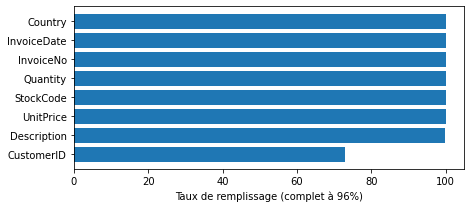

In [8]:
missing = source.isnull().sum().reset_index()
missing.columns = ['variables', 'nb vides']
missing['% remplissage'] = round(((source.shape[0] - missing['nb vides']) / source.shape[0] * 100 ), 2)
missing = missing.sort_values(['nb vides', 'variables'], ascending=False).reset_index(drop = True) 
fig = plt.figure(figsize=(7, 3)) 
plt.barh(missing['variables'], missing['% remplissage'] ) 
#plt.xticks(range(21), range(80, 101)) 
taille = source.shape[0] * source.shape[1] 
plt.xlabel('Taux de remplissage (complet à {}%)'.format(int((taille - missing['nb vides'].sum())/taille*100)))

In [9]:
source = source.dropna(subset=['CustomerID']).reset_index(drop=True) 
source.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 361878 entries, 0 to 361877
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    361878 non-null  object        
 1   StockCode    361878 non-null  object        
 2   Description  361878 non-null  object        
 3   Quantity     361878 non-null  int64         
 4   InvoiceDate  361878 non-null  datetime64[ns]
 5   UnitPrice    361878 non-null  float64       
 6   CustomerID   361878 non-null  object        
 7   Country      361878 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(1), object(5)
memory usage: 22.1+ MB


In [10]:
source

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-01-12 08:26:00,2.55,17850,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-01-12 08:26:00,3.39,17850,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-01-12 08:26:00,2.75,17850,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-01-12 08:26:00,3.39,17850,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-01-12 08:26:00,3.39,17850,United Kingdom
...,...,...,...,...,...,...,...,...
361873,581585,22466,FAIRY TALE COTTAGE NIGHT LIGHT,12,2011-09-12 12:31:00,1.95,15804,United Kingdom
361874,581586,22061,LARGE CAKE STAND HANGING STRAWBERY,8,2011-09-12 12:49:00,2.95,13113,United Kingdom
361875,581586,23275,SET OF 3 HANGING OWLS OLLIE BEAK,24,2011-09-12 12:49:00,1.25,13113,United Kingdom
361876,581586,21217,RED RETROSPOT ROUND CAKE TINS,24,2011-09-12 12:49:00,8.95,13113,United Kingdom


## Description

In [11]:
test = source[['StockCode', 'Description']].drop_duplicates() 
test[test.duplicated(subset='StockCode', keep=False)].sort_values(by=['StockCode']) #.to_excel("test.xlsx")

,StockCode,Description
83550,16156L,WRAP CAROUSEL
27550,16156L,"WRAP, CAROUSEL"
213413,17107D,FLOWER FAIRY 5 DRAWER LINERS
4171,17107D,"FLOWER FAIRY,5 SUMMER B'DRAW LINERS"
224810,17107D,FLOWER FAIRY 5 SUMMER DRAW LINERS
...,...,...
22555,90014A,SILVER/MOP ORBIT NECKLACE
17085,90014B,GOLD M PEARL ORBIT NECKLACE
253550,90014B,GOLD M.O.P. ORBIT NECKLACE
338254,90014C,SILVER AND BLACK ORBIT NECKLACE


In [12]:
Pdt = source.groupby('StockCode').Description.agg(pd.Series.mode).reset_index()
Pdt.describe(include='all')

,StockCode,Description
count,3661,3661
unique,3661,3643
top,22574,"METAL SIGN,CUPCAKE SINGLE HOOK"
freq,1,3


In [13]:
source.drop(['Description'], axis=1, inplace=True) 
source = source.merge(Pdt, on="StockCode", ) 
source.describe(include='all')
#= source.StockCode.apply(lambda x: Pdt[Pdt.StockCode == x].Description.values)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  This is separate from the ipykernel package so we can avoid doing imports until


,InvoiceNo,StockCode,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Description
count,361878,361878,361878.000000,361878,361878.000000,361878,361878,361878
unique,19857,3661,NaN,18441,NaN,3950,1,3643
top,576339,85123A,NaN,2011-11-14 15:27:00,NaN,17841,United Kingdom,WHITE HANGING HEART T-LIGHT HOLDER
freq,542,1987,NaN,543,NaN,7983,361878,1987
first,NaN,NaN,NaN,2010-01-12 08:26:00,NaN,NaN,NaN,NaN
last,NaN,NaN,NaN,2011-12-10 17:19:00,NaN,NaN,NaN,NaN
mean,NaN,NaN,11.077029,NaN,3.256007,NaN,NaN,NaN
std,NaN,NaN,263.129266,NaN,70.654731,NaN,NaN,NaN
min,NaN,NaN,-80995.000000,NaN,0.000000,NaN,NaN,NaN
25%,NaN,NaN,2.000000,NaN,1.250000,NaN,NaN,NaN


In [14]:
def most_common_words(labels, sep):
    words = []
    for i, lab in labels.items():
        lab = '|'.join([x.strip() for x in str(lab).split(sep) ]) 
        if lab != '':
            words += lab.split('|') 
#    words.pop('')
    return Counter(words).most_common() 

In [15]:
keywords = dict(most_common_words(source.Description, ' ') ) 
keywords_kp = {} 
for k, v in keywords.items(): 
    if len(k) >= 3:
        keywords_kp[k] = v   
len(keywords_kp )

2133

## Doublons

In [16]:
print('Entrées dupliquées: {}'.format(source.duplicated(subset=['InvoiceNo', 'StockCode', 'Quantity', 'InvoiceDate', 'UnitPrice', 'CustomerID']).sum()))
source.drop_duplicates(inplace = True, subset=['InvoiceNo', 'StockCode', 'Quantity', 'InvoiceDate', 'UnitPrice', 'CustomerID'], ignore_index=True)

Entrées dupliquées: 5152


In [17]:
source.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 356726 entries, 0 to 356725
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    356726 non-null  object        
 1   StockCode    356726 non-null  object        
 2   Quantity     356726 non-null  int64         
 3   InvoiceDate  356726 non-null  datetime64[ns]
 4   UnitPrice    356726 non-null  float64       
 5   CustomerID   356726 non-null  object        
 6   Country      356726 non-null  object        
 7   Description  356726 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(1), object(5)
memory usage: 21.8+ MB


## Codes produit (StockCode)

In [18]:
mask = source.StockCode.str.contains('[0-9]{5}')
source[~mask][['StockCode', 'Description']].value_counts()

StockCode     Description               
M             Manual                        380
POST          POSTAGE                        86
D             Discount                       74
C2            CARRIAGE                       30
DOT           DOTCOM POSTAGE                 16
CRUK          CRUK Commission                16
BANK CHARGES  Bank Charges                   12
PADS          PADS TO MATCH ALL CUSHIONS      4
dtype: int64

In [19]:
source.drop(index=source[~mask].index, inplace=True) 

## Commandes annulées

In [20]:
# Tri du jeu de données (date, client, facture, produit, PU)
source = source.sort_values(by=['InvoiceDate', 'CustomerID', 'InvoiceNo', 'StockCode', 'UnitPrice']).reset_index(drop=True)

In [21]:
mask = source.InvoiceNo.str.contains('^C', regex=True)

In [22]:
Cancel_Orders = source[source.InvoiceNo.str.contains('^C', regex=True) ].copy() 
Orders = source[(~source.InvoiceNo.str.contains('^C', regex=True)) ].reset_index().merge(Cancel_Orders[['CustomerID', 'UnitPrice', 'StockCode']].drop_duplicates())
end = Cancel_Orders.shape[0]
#tmp = source[~mask].copy() 
while end: 
    print( "{} Orders, {} Cancels".format(len(Orders), len(Cancel_Orders)))
    Cnl_idx = [] 
    Can = 0 
    c = 0  
    o = 0  
    for i, j in Cancel_Orders.iterrows():
        Can += 1
        if not Can % 1000: 
            print(Can, c, o)
        try: 
            idx = max( Orders[(Orders.CustomerID == j.CustomerID) & \
                              (Orders.UnitPrice == j.UnitPrice) & \
    #                              (Orders.Quantity >= j.Quantity * -1) & \
                              (Orders.StockCode == j.StockCode) & \
                              (Orders.InvoiceDate < j.InvoiceDate)]['index']) 
            idx_ord = Orders[Orders['index'] == idx].index[0]

            ecart  = Orders.loc[idx_ord, 'Quantity'] + j.Quantity 
            if ecart >= 0: 
                c += 1 
                Cnl_idx.append(i) 
                if ecart == 0: 
                    o += 1 
                    Cnl_idx.append(idx) 
                else: 
                    source.loc[idx, 'Quantity'] = ecart
            else: 
                source.loc[i, 'Quantity'] = ecart 
                o += 1 
                Cnl_idx.append(idx) 
            Orders.drop(index=idx_ord, inplace=True)
        except ValueError: 
            continue 
    end = c 
    print(Can, c, o, len(Cnl_idx), '\n')
    source.drop(index=Cnl_idx, inplace=True)
    Cancel_Orders = source[source.InvoiceNo.str.contains('^C', regex=True) ].copy() 
    Orders = source[(~source.InvoiceNo.str.contains('^C', regex=True)) ].reset_index().merge(Cancel_Orders[['CustomerID', 'UnitPrice', 'StockCode']].drop_duplicates())
#source.reset_index(drop=True, inplace=True)
source.describe(include='all')

13104 Orders, 7218 Cancels
1000 331 127
2000 882 370
3000 1461 582
4000 2083 859
5000 2841 1107
6000 3637 1390
7000 4455 1721
7218 4621 1783 6404 

2876 Orders, 2597 Cancels
1000 16 6
2000 76 24
2597 160 55 215 

2430 Orders, 2437 Cancels
1000 1 0
2000 6 1
2437 14 1 15 

2400 Orders, 2423 Cancels
1000 0 0
2000 3 1
2423 3 1 4 

2399 Orders, 2420 Cancels
1000 0 0
2000 3 2
2420 3 2 5 

2390 Orders, 2417 Cancels
1000 0 0
2000 0 0
2417 0 0 0 



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:43: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.


,InvoiceNo,StockCode,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Description
count,349465,349465,349465.000000,349465,349465.000000,349465,349465,349465
unique,17632,3652,NaN,16501,NaN,3939,1,3634
top,576339,85123A,NaN,2011-11-14 15:27:00,NaN,17841,United Kingdom,WHITE HANGING HEART T-LIGHT HOLDER
freq,541,1939,NaN,541,NaN,7628,349465,1939
first,NaN,NaN,NaN,2010-01-12 08:26:00,NaN,NaN,NaN,NaN
last,NaN,NaN,NaN,2011-12-10 17:19:00,NaN,NaN,NaN,NaN
mean,NaN,NaN,11.424011,NaN,2.865400,NaN,NaN,NaN
std,NaN,NaN,49.962911,NaN,4.308526,NaN,NaN,NaN
min,NaN,NaN,-9360.000000,NaN,0.000000,NaN,NaN,NaN
25%,NaN,NaN,2.000000,NaN,1.250000,NaN,NaN,NaN


In [23]:
source[(source.StockCode == '71053') & (source.CustomerID == '16094')].sort_values(by='InvoiceDate')

,InvoiceNo,StockCode,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Description
144083,C540380,71053,-1,2011-06-01 17:36:00,3.75,16094,United Kingdom,WHITE METAL LANTERN
264876,C552701,71053,-1,2011-10-05 15:58:00,3.75,16094,United Kingdom,WHITE METAL LANTERN
271909,575698,71053,4,2011-10-11 16:51:00,3.75,16094,United Kingdom,WHITE METAL LANTERN


In [24]:
source[(source.Quantity <= 0) & ~(source.InvoiceNo.str.contains('^C', regex=True)) ]

,InvoiceNo,StockCode,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Description


In [25]:
print("{} Cancels restantes".format(len(Cancel_Orders)) ) 
source.drop(index=Cancel_Orders.index, inplace=True)
source[source.InvoiceNo.str.contains('^C', regex=True)]

2417 Cancels restantes


,InvoiceNo,StockCode,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Description


In [26]:
source[(source.UnitPrice == 0) | (source.Quantity == 0)]

,InvoiceNo,StockCode,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Description
21028,539263,22580,4,2010-12-16 14:36:00,0.0,16560,United Kingdom,ADVENT CALENDAR GINGHAM SACK
35239,541109,22168,1,2011-01-13 15:10:00,0.0,15107,United Kingdom,ORGANISER WOOD ANTIQUE WHITE
74165,574175,22065,12,2011-03-11 11:47:00,0.0,14110,United Kingdom,CHRISTMAS PUDDING TRINKET POT
83476,547417,22062,36,2011-03-23 10:25:00,0.0,13239,United Kingdom,CERAMIC BOWL WITH LOVE HEART DESIGN
89807,548318,22055,5,2011-03-30 12:45:00,0.0,13113,United Kingdom,MINI CAKE STAND HANGING STRAWBERY
94466,548871,22162,2,2011-04-04 14:42:00,0.0,14410,United Kingdom,HEART GARLAND RUSTIC PADDED
143929,540372,22090,24,2011-06-01 16:41:00,0.0,13081,United Kingdom,PAPER BUNTING RETROSPOT
143955,540372,22553,24,2011-06-01 16:41:00,0.0,13081,United Kingdom,PLASTERS IN TIN SKULLS
150273,569716,22778,2,2011-06-10 08:17:00,0.0,15804,United Kingdom,GLASS CLOCHE SMALL
182459,574879,22625,2,2011-07-11 13:22:00,0.0,13014,United Kingdom,RED KITCHEN SCALES


In [27]:
source.drop(index=source[(source.UnitPrice == 0) | (source.Quantity == 0)].index, inplace=True)

In [28]:
source.isnull().sum()

InvoiceNo      0
StockCode      0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
Description    0
dtype: int64

## Calcul des montants totaux (TotalPrice)

In [29]:
source['TotalPrice'] = source.Quantity * source.UnitPrice 
source 

,InvoiceNo,StockCode,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Description,TotalPrice
0,536365,21730,6,2010-01-12 08:26:00,4.25,17850,United Kingdom,GLASS STAR FROSTED T-LIGHT HOLDER,25.50
1,536365,22752,2,2010-01-12 08:26:00,7.65,17850,United Kingdom,SET 7 BABUSHKA NESTING BOXES,15.30
2,536365,71053,6,2010-01-12 08:26:00,3.39,17850,United Kingdom,WHITE METAL LANTERN,20.34
3,536365,84029E,6,2010-01-12 08:26:00,3.39,17850,United Kingdom,RED WOOLLY HOTTIE WHITE HEART.,20.34
4,536365,84029G,6,2010-01-12 08:26:00,3.39,17850,United Kingdom,KNITTED UNION FLAG HOT WATER BOTTLE,20.34
...,...,...,...,...,...,...,...,...,...
356103,570876,23509,4,2011-12-10 17:19:00,0.42,16085,United Kingdom,MINI PLAYING CARDS FUN FAIR,1.68
356104,570876,23510,4,2011-12-10 17:19:00,0.42,16085,United Kingdom,MINI PLAYING CARDS GYMKHANA,1.68
356105,570876,46000M,1,2011-12-10 17:19:00,1.55,16085,United Kingdom,POLYESTER FILLER PAD 45x45cm,1.55
356106,570876,46000S,1,2011-12-10 17:19:00,1.45,16085,United Kingdom,POLYESTER FILLER PAD 40x40cm,1.45


## Réduction temporelle

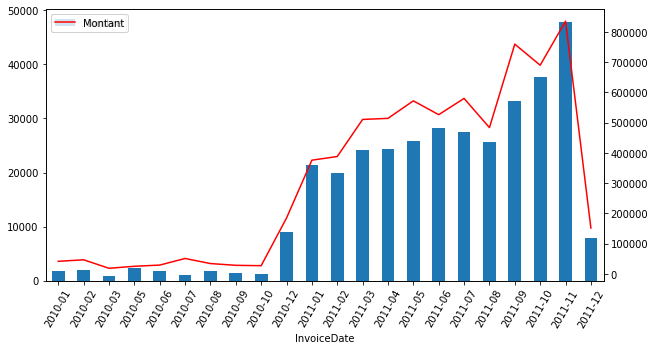

In [30]:
fig = plt.figure(figsize=(10, 5) )
tmp = source.groupby(source.InvoiceDate.dt.strftime('%Y-%m')).TotalPrice.agg([('Nombre', 'count'),('Montant', 'sum')])
ax1 = plt.subplot()
tmp.plot(kind='bar', y='Nombre', ax=ax1) 
plt.xticks(rotation=60)
ax2 = ax1.twinx()
tmp.plot(y='Montant', kind='line', color='red', ax=ax2)

In [31]:
backup = source.copy() 

In [32]:
source = backup.copy() 
source = source[(source.InvoiceDate >= '2011-01-01') & (source.InvoiceDate < '2011-09-01')]

## Classification 'Recency/Frequency/Monetary' des clients (feature engineering)
http://www.blastam.com/blog/rfm-analysis-boosts-sales 

<table id="table" style="border-color: #827d7d;" border="2" cellspacing="2" cellpadding="2">
<tbody>
<tr>
<td style="border-color: #827d7d; width: 25%; text-align: center; background-color: #11a4e7;"><strong><span style="color: #ffffff;">Segment</span></strong></td>
<td style="border-color: #827d7d; width: 10%; text-align: center; background-color: #11a4e7;"><strong><span style="color: #ffffff;">RFM</span></strong></td>
<td style="border-color: #827d7d; width: 32%; text-align: center; background-color: #11a4e7;"><strong><span style="color: #ffffff;">Description</span></strong></td>
<td style="border-color: #827d7d; width: 32%; text-align: center; background-color: #11a4e7;"><strong><span style="color: #ffffff;">Marketing</span></strong></td>
</tr>
<tr>
<td>Best Customers</td>
<td>111</td>
<td><span style="font-weight: 400;">Bought most recently and most often, and spend the most</span></td>
<td><span style="font-weight: 400;">No price incentives, new products, and loyalty programs</span></td>
</tr>
<tr>
<td>Loyal Customers</td>
<td>X1X</td>
<td><span style="font-weight: 400;">Buy most frequently</span></td>
<td><span style="font-weight: 400;">Use R and M to further segment</span></td>
</tr>
<tr>
<td>Big Spenders</td>
<td>XX1</td>
<td>Spend the most</td>
<td>Market your most expensive products</td>
</tr>
<tr>
<td>Almost Lost</td>
<td>311</td>
<td><span style="font-weight: 400;">Haven&#8217;t purchased for some time, but purchased frequently and spend the most</span></td>
<td><span style="font-weight: 400;">Aggressive price incentives</span></td>
</tr>
<tr>
<td>Lost Customers</td>
<td>411</td>
<td><span style="font-weight: 400;">Haven&#8217;t purchased for some time, but purchased frequently and spend the most</span></td>
<td><span style="font-weight: 400;">Aggressive price incentives</span></td>
</tr>
<tr>
<td>Lost Cheap Customers</td>
<td>444</td>
<td><span style="font-weight: 400;">Last purchased long ago, purchased few, and spent little</span></td>
<td><span style="font-weight: 400;">Don&#8217;t spend too much trying to re-acquire</span></td>
</tr>
</tbody>
</table>

In [33]:
def rfmScore(x, p, d): 
    if x <= d[p][0.25]:
        return (4 if d[p]['asc'] else 1 ) * d[p]['coef']
    elif x <= d[p][0.50]:
        return (3 if d[p]['asc'] else 2 ) * d[p]['coef']
    elif x <= d[p][0.75]: 
        return (2 if d[p]['asc'] else 3 ) * d[p]['coef']
    else:
        return (1 if d[p]['asc'] else 4 ) * d[p]['coef']

In [34]:
d_study = source.InvoiceDate.max() + timedelta(days=1) #dt.datetime(2012,1,1)
d_study 

Timestamp('2011-09-01 17:16:00')

In [35]:
#rfmTable.merge(source.groupby('CustomerID').TotalPrice.agg(['min', 'max', 'mean', ('monetary_value', 'sum')]).reset_index())

In [36]:
rfmTable = source.groupby('CustomerID').agg({'InvoiceDate': lambda x: (d_study - x.max()).days, \
                                             'StockCode': lambda x: len(x), \
#                                             'TotalPrice': lambda x: x.sum(), \
                                             'InvoiceNo': lambda x: len(x.unique())}).reset_index() 
rfmTable['InvoiceDate'] = rfmTable['InvoiceDate'].astype(int)
rfmTable.rename(columns={'InvoiceDate': 'recency', 'StockCode': 'frequency', 'InvoiceNo': 'Orders'}, inplace=True)
rfmTable  = rfmTable.merge(source.groupby('CustomerID').TotalPrice.agg([('monetary_value', 'sum'), ('price_mean', 'mean'), ('price_min', 'min'), ('price_max', 'max')]).reset_index()) 
rfmTable['MeanPdt'] = (rfmTable['frequency'] / rfmTable['Orders'] ).astype(int)
rfmTable = rfmTable.reindex(columns=['CustomerID','recency', 'frequency', 'monetary_value', 'Orders', 'MeanPdt', 'price_mean', 'price_min', 'price_max'])
rfmTable.describe()

,recency,frequency,monetary_value,Orders,MeanPdt,price_mean,price_min,price_max
count,3038.000000,3038.000000,3038.000000,3038.000000,3038.000000,3038.000000,3038.000000,3038.000000
mean,84.092824,64.880184,1299.413654,3.207373,20.813035,34.874845,15.700296,104.585059
std,66.340566,132.975670,4249.665485,4.847811,19.710398,147.062266,123.419378,269.863236
min,1.000000,1.000000,2.900000,1.000000,1.000000,1.450000,0.100000,1.650000
25%,26.000000,14.000000,235.645000,1.000000,9.000000,11.503766,1.100000,30.000000
50%,69.000000,31.000000,507.145000,2.000000,16.000000,17.247938,5.040000,47.700000
75%,134.000000,72.000000,1176.575000,3.000000,27.000000,24.462053,9.960000,94.725000
max,242.000000,4380.000000,140176.690000,101.000000,270.000000,4307.180000,3861.000000,6539.400000


### Outliers

In [37]:
quantiles = rfmTable.iloc[:, :-3].quantile(q=[0.25,0.5,0.75], ) #
quantiles = quantiles.to_dict()
quantiles['recency']['asc'] = False
quantiles['recency']['coef'] = 100 
quantiles['frequency']['asc'] = True
quantiles['frequency']['coef'] = 10 
quantiles['monetary_value']['asc'] = True
quantiles['monetary_value']['coef'] = 1 
quantiles

{'MeanPdt': {0.25: 9.0, 0.5: 16.0, 0.75: 27.0},
 'Orders': {0.25: 1.0, 0.5: 2.0, 0.75: 3.0},
 'frequency': {0.25: 14.0, 0.5: 31.0, 0.75: 72.0, 'asc': True, 'coef': 10},
 'monetary_value': {0.25: 235.64499999999992,
  0.5: 507.145,
  0.75: 1176.5749999999998,
  'asc': True,
  'coef': 1},
 'recency': {0.25: 26.0, 0.5: 69.0, 0.75: 134.0, 'asc': False, 'coef': 100}}

In [38]:
outliers_lst  = []

# For each feature find the data points with extreme high or low values
for feature in quantiles.keys():
    # TODO: Calculate Q1 (25th percentile of the data) for the given feature
    Q1 = np.percentile(rfmTable.loc[:, feature], 25)

    # TODO: Calculate Q3 (75th percentile of the data) for the given feature
    Q3 = np.percentile(rfmTable.loc[:, feature], 75)

    # TODO: Use the interquartile range to calculate an outlier step (1.5 times the interquartile range)
    step = 1.5 * (Q3 - Q1)

    # So here, we're finding any points outside of Q1 - step and Q3 + step
    outliers_rows = rfmTable.loc[~((rfmTable[feature] >= Q1 - step) & (rfmTable[feature] <= Q3 + step)), :]

    # Display the outliers
    print ("Outliers '{}' {}".format(feature, len(outliers_rows)))

    outliers_lst.append(list(outliers_rows.index))

outliers = list(itertools.chain.from_iterable(outliers_lst))

rfmTable.drop(index=list(set(outliers)), inplace=True)
rfmTable.reset_index(drop=True)
rfmTable.describe()

Outliers 'recency' 0
Outliers 'frequency' 263
Outliers 'monetary_value' 290
Outliers 'Orders' 316
Outliers 'MeanPdt' 169


,recency,frequency,monetary_value,Orders,MeanPdt,price_mean,price_min,price_max
count,2457.000000,2457.000000,2457.000000,2457.000000,2457.000000,2457.000000,2457.000000,2457.000000
mean,93.191290,33.648759,567.428205,1.986569,16.926740,27.541201,12.424204,72.780513
std,66.437788,30.280689,499.772675,1.241675,11.599429,47.482180,37.181700,92.510071
min,1.000000,1.000000,2.900000,1.000000,1.000000,1.450000,0.100000,1.650000
25%,37.000000,12.000000,204.920000,1.000000,8.000000,12.776842,1.650000,29.950000
50%,80.000000,24.000000,389.270000,2.000000,15.000000,17.330000,6.240000,41.600000
75%,144.000000,46.000000,763.960000,3.000000,23.000000,23.850000,10.200000,81.120000
max,242.000000,154.000000,2585.240000,6.000000,54.000000,743.800000,600.000000,1250.000000


In [39]:
#rfmTable['Orders'] = [ t if t < 4 else 4 for t in rfmTable.Orders] 
#rfmTable

In [40]:
# Commandes uniques 
print('Commandes uniques :\n\tPourcentage : {:.2f}%\n\tPanier moyen : {:.2f}'.\
      format(len(rfmTable[rfmTable.Orders == 1]) / len(rfmTable) *100, \
             rfmTable[rfmTable.Orders == 1].monetary_value.mean()))

Commandes uniques :
	Pourcentage : 48.60%
	Panier moyen : 283.76


In [41]:
#rfmTable.drop(index=rfmTable[rfmTable.monetary_value <= 0].index, inplace=True)

### Distribution des variables

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

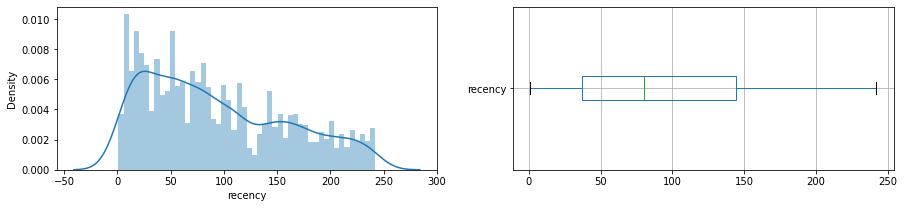

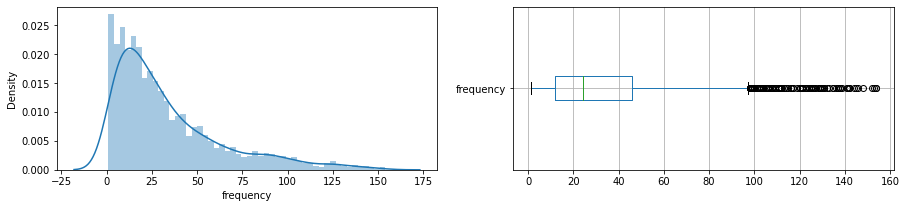

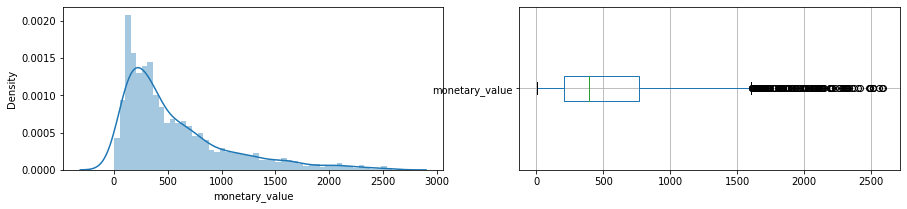

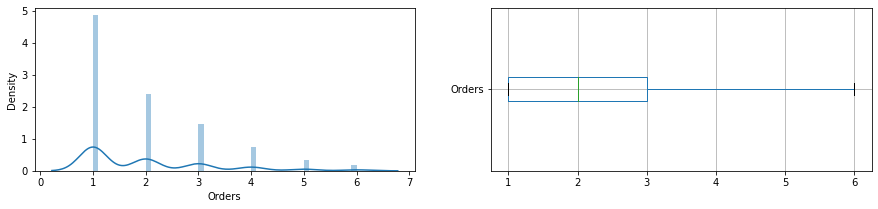

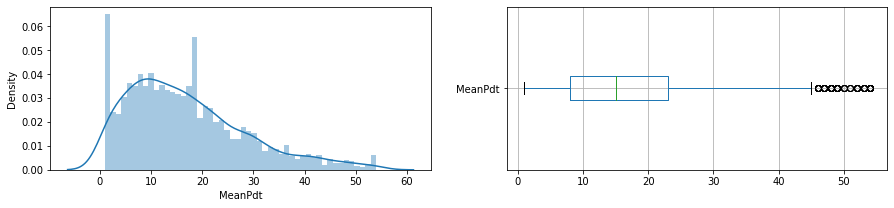

In [42]:
#rfmcols = rfmTable.columns[1:-2] 
for col in quantiles.keys(): 
    fig = plt.figure(figsize=(15, 3)) 
    plt.subplot(1, 2, 1) 
    q90 = quantiles[col][0.75] + 1.5 * (quantiles[col][0.75] - quantiles[col][0.25])
    sns.distplot(rfmTable[rfmTable[col].values <= q90][col], kde=True, bins=50, norm_hist=True ) 
    plt.subplot(1, 2, 2) 
    rfmTable.boxplot(column=col, vert=False) 

### Analyse bivariée

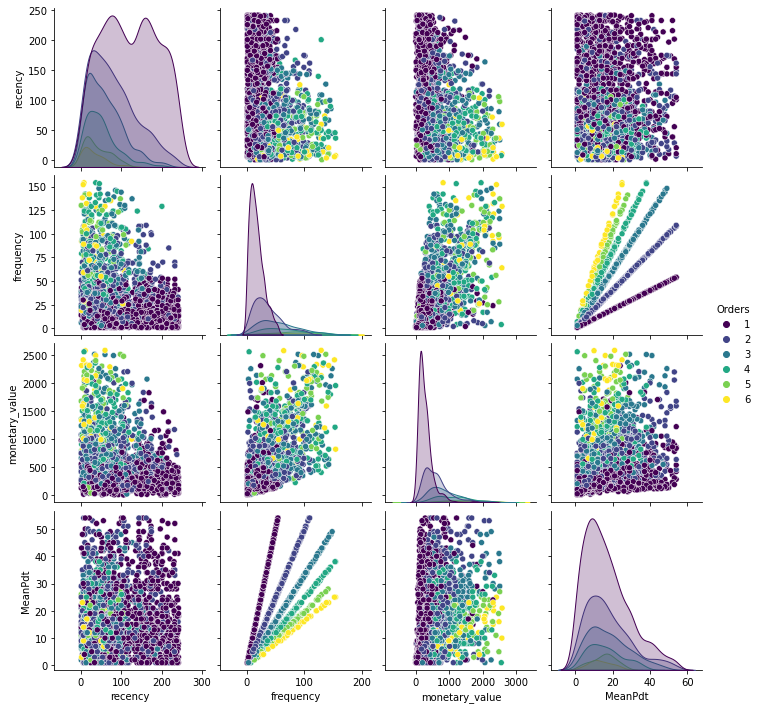

In [43]:
sns.pairplot(rfmTable[quantiles.keys()], hue='Orders', palette='viridis')

In [44]:
rfmTable['rfmScore'] = 0
for col in ['recency', 'frequency', 'monetary_value'] : 
    rfmTable['rfmScore'] += rfmTable[col].apply(rfmScore, args=(col, quantiles)) 
rfmTable.sort_values(by=['rfmScore', 'recency', 'frequency', 'monetary_value'], ascending=[True, True, False, False])[:10]

,CustomerID,recency,frequency,monetary_value,Orders,MeanPdt,price_mean,price_min,price_max,rfmScore
972,14525,1,130,1679.53,5,26,12.919462,0.42,163.20,111
588,13870,2,92,2315.42,6,15,25.167609,4.95,207.50,111
2921,18077,4,138,1592.07,6,23,11.536739,1.45,85.92,111
1887,16186,4,104,1911.17,5,20,18.376635,5.04,70.80,111
2041,16456,4,94,1370.78,4,23,14.582766,0.19,104.00,111
2152,16670,6,152,2415.66,6,25,15.892500,3.36,35.70,111
1342,15203,6,105,1328.32,4,26,12.650667,3.42,33.00,111
1586,15641,6,99,1578.83,3,33,15.947778,2.88,59.40,111
659,13994,6,94,1304.77,4,23,13.880532,1.70,49.50,111
1140,14837,6,90,1337.26,3,30,14.858444,4.56,25.20,111


# Clustering

In [45]:
#X_train, X_test, y_train, y_test = \
#    model_selection.train_test_split(rfmTable[quantiles.keys()], rfmTable['rfmScore'], test_size=0.3 ) # 30% des données dans le jeu de test 

X_train = rfmTable[quantiles.keys()] 

std_scale = preprocessing.StandardScaler().fit(X_train)
X_train_scaled = std_scale.transform(X_train)
#X_test_scaled = std_scale.transform(X_test) 
X_train_scaled.shape #, X_test_scaled.shape 

(2457, 5)

## PCA

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


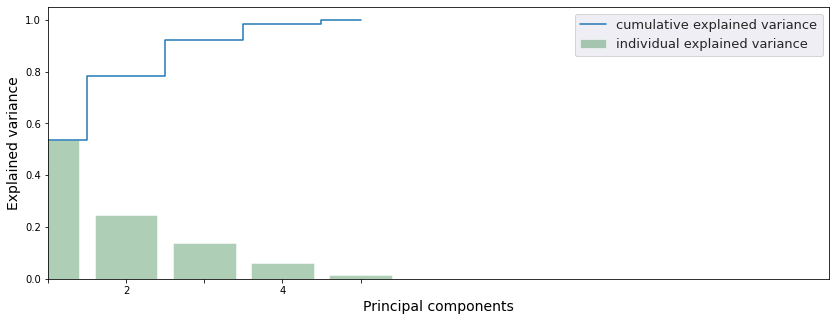

In [46]:
pca = decomposition.PCA()
pca.fit(X_train_scaled)
X_trans = pca.transform(X_train_scaled)

fig, ax = plt.subplots(figsize=(14, 5))
sns.set(font_scale=1)
plt.step(range(X_train.shape[1]), pca.explained_variance_ratio_.cumsum(), where='mid',
         label='cumulative explained variance')
sns.barplot(np.arange(1,X_train.shape[1]+1), pca.explained_variance_ratio_, alpha=0.5, color = 'g',
            label='individual explained variance')
plt.xlim(0, 10)

ax.set_xticklabels([s if int(s.get_text())%2 == 0 else '' for s in ax.get_xticklabels()])

plt.ylabel('Explained variance', fontsize = 14)
plt.xlabel('Principal components', fontsize = 14)
plt.legend(loc='best', fontsize = 13) 

PCA 2 composants : [0.53766381 0.2470826 ] 0.7847464100066165


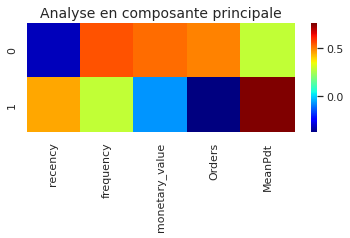

In [47]:
pca = decomposition.PCA(n_components=2)
X_trans = pca.fit_transform(X_train_scaled)
print("PCA", len(pca.components_), "composants :", pca.explained_variance_ratio_, pca.explained_variance_ratio_.sum())

map= pd.DataFrame(pca.components_,columns=X_train.columns) 
plt.figure(figsize=(6,2)) 
plt.title('Analyse en composante principale', fontdict={'fontsize' : 14}, )
sns.heatmap(map, cmap='jet')

(-0.7, 0.7)

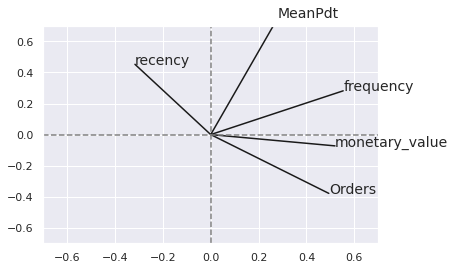

In [48]:
pcs = pca.components_

for i, (x, y) in enumerate(zip(pcs[0, :], pcs[1, :])):
    # Afficher un segment de l'origine au point (x, y)
    plt.plot([0, x], [0, y], color='k')
    # Afficher le nom (data.columns[i]) de la performance
    plt.text(x, y, X_train.columns[i], fontsize='14')

# Afficher une ligne horizontale y=0
plt.plot([-0.7, 0.7], [0, 0], color='grey', ls='--')

# Afficher une ligne verticale x=0
plt.plot([0, 0], [-0.7, 0.7], color='grey', ls='--')

plt.xlim([-0.7, 0.7])
plt.ylim([-0.7, 0.7])

## KMeans

best clustering =  4


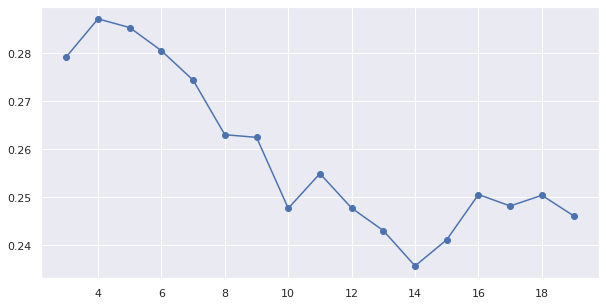

In [49]:
fig = plt.figure(figsize=(10, 5))
# Iteration de clustering kmeans avec des nb de clusters différents 
silhouettes = [] 
cluster_range = range(3, 20)
for n in cluster_range: 
    myclust = cluster.KMeans(n_clusters=n) 
    myclust.fit(X_train_scaled) 
    silhouettes.append(metrics.silhouette_score(X_train_scaled, myclust.labels_)) 

plt.plot(cluster_range, silhouettes, marker='o') 

best_cluster = cluster_range[np.argmax(silhouettes)]
print('best clustering = ', best_cluster)

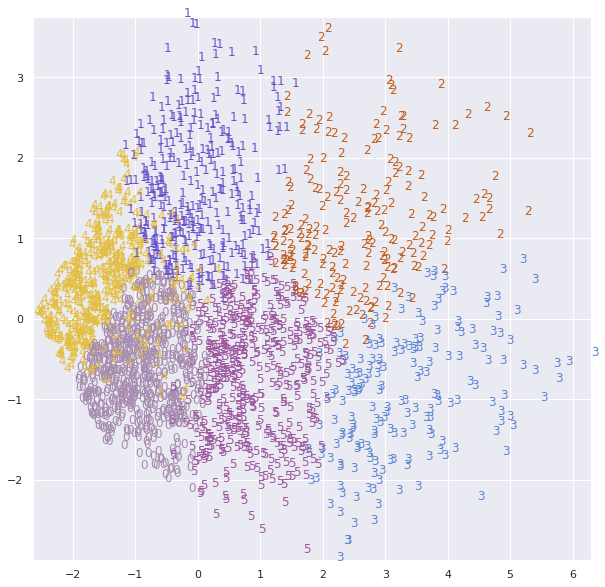

Silhouette Coefficient: 0.280


In [50]:
nb_clusters = 6 
color = ["#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)])
        for i in range(nb_clusters)]

fig = plt.figure(figsize=(10, 10))

# Clustering avec kmeans 
myclust = cluster.KMeans(n_clusters=nb_clusters)
myclust.fit(X_train_scaled)

# Puis on visualise, selon la méthode donnée dans le coup de pouce :
for i in range(X_trans.shape[0]): # pour chaque point
    plt.text(X_trans[i, 0], X_trans[i, 1], myclust.labels_[i],
            color=color[myclust.labels_[i]] ) #plt.cm.Set2(myclust.labels_[i]/10.))

# On redéfinit les axes pour bien voir tous les points
#plt.xlim(np.around([np.min(X_trans[:, 0]), np.max(X_trans[:, 0])], decimals=-1))
#plt.ylim(np.around([np.min(X_trans[:, 1]), np.max(X_trans[:, 1])], decimals=-1))
plt.xlim(np.min(X_trans[:, 0]), np.max(X_trans[:, 0]))
plt.ylim(np.min(X_trans[:, 1]), np.max(X_trans[:, 1]))

# On affiche l'image
plt.show()

# 3. Évaluation
# Pour l’évaluation intrinsèque, je choisis le coefficient de silhouette :
print("Silhouette Coefficient: %0.3f" % metrics.silhouette_score(X_train_scaled, myclust.labels_))

# Pour la comparaison aux étiquettes, je choisis l’indice de Rand ajusté :
#print("Adjusted Rand Index: %0.3f"
#      % metrics.adjusted_rand_score(y.titleID, myclust.labels_))

In [51]:
pd.DataFrame(pd.Series(myclust.labels_).value_counts(), columns = ['nb. de clients']).T

,0,4,5,1,2,3
nb. de clients,687,531,478,359,213,189


In [52]:
rfmTable['cluster'] = pd.Series(myclust.labels_).values 
rfmTable

,CustomerID,recency,frequency,monetary_value,Orders,MeanPdt,price_mean,price_min,price_max,rfmScore,cluster
2,12749,81,124,2492.81,3,41,20.103306,7.50,102.00,311,2
3,12820,81,23,380.81,2,11,16.556957,6.96,37.80,333,0
4,12823,145,4,1224.00,4,1,306.000000,229.50,459.00,441,5
5,12826,51,54,799.62,4,13,14.807778,4.56,35.40,222,5
6,12827,52,10,212.40,2,5,21.240000,10.20,44.55,244,0
...,...,...,...,...,...,...,...,...,...,...,...
3032,18272,14,100,1709.82,4,25,17.098200,6.64,50.40,111,3
3033,18273,51,3,204.00,3,1,68.000000,51.00,102.00,244,0
3034,18280,60,10,180.60,1,10,18.060000,14.85,23.70,244,0
3035,18282,116,12,176.60,2,6,14.716667,5.04,25.50,344,0


## DBSCAN

clusters : 2055
bruit : 402


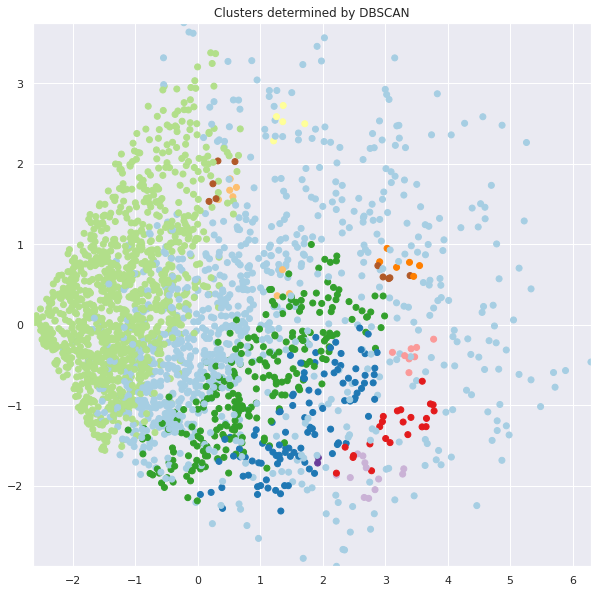

In [53]:
db = DBSCAN(eps=.5, min_samples=5)
db.fit(X_train_scaled) 

y_pred = db.fit_predict(X_train_scaled)
fig = plt.figure(figsize=(10, 10))
plt.scatter(X_trans[:,0], X_trans[:,1], c=y_pred, cmap='Paired', )
plt.xlim(np.min(X_trans[:, 0]), np.max(X_trans[:, 0]))
plt.ylim(np.min(X_trans[:, 1]), np.max(X_trans[:, 1]))

plt.title("Clusters determined by DBSCAN")

print('clusters :', db.labels_[db.labels_ != -1].size) 
print('bruit :', db.labels_[db.labels_ == -1].size) 

# Classification

In [54]:
X_train, X_test, y_train, y_test = \
    model_selection.train_test_split(rfmTable[quantiles.keys()], rfmTable['cluster'], test_size=0.3 ) # 30% des données dans le jeu de test 

std_scale = preprocessing.StandardScaler().fit(X_train)
X_train_scaled = std_scale.transform(X_train)
X_test_scaled = std_scale.transform(X_test) 
X_train_scaled.shape, X_test_scaled.shape 

((1719, 5), (738, 5))

## k-Nearest Neighbors

In [55]:
Knn = KNeighborsClassifier() 
params = {'n_neighbors': np.arange(1,50,1)}

gs_knn = GridSearchCV(Knn, params, cv=5, scoring = 'accuracy',n_jobs=-1)

gs_knn.fit(X_train_scaled, y_train)

print(gs_knn.best_params_)

{'n_neighbors': 8}


In [56]:
y_pred = gs_knn.predict(X_test) 
print("Precision: {:.2f} % ".format(100*metrics.accuracy_score(y_test, y_pred))) 

Precision: 11.92 % 


## Support Vector Machine Classifier (SVC)

In [57]:
svm = LinearSVC(dual=False, multi_class='ovr') 
params = { 'C': np.logspace(-3, 3, 7), 'loss': ['hinge','squared_hinge'], 'penalty' : ['l1', 'l2']}
#params = { 'C': [50,100,150], 'loss': ['hinge','squared_hinge']}

gs_svm = GridSearchCV(svm, params, cv=5, scoring = 'accuracy',n_jobs=-1)

gs_svm.fit(X_train_scaled, y_train)

print(gs_svm.best_params_)

{'C': 10.0, 'loss': 'squared_hinge', 'penalty': 'l1'}


In [58]:
y_pred = gs_svm.predict(X_test) 
print("Precision: {:.2f} % ".format(100*metrics.accuracy_score(y_test, y_pred))) 

Precision: 23.98 % 


## Random Forrest

In [59]:
rfc = RandomForestClassifier() 
params = {'criterion' : ['entropy', 'gini'], 'n_estimators' : [20, 40, 60, 80, 100],
               'max_features' :['sqrt', 'log2']}

gs_rfc = GridSearchCV(rfc, params, cv=5, scoring = 'accuracy',n_jobs=-1)

gs_rfc.fit(X_train_scaled, y_train)

print(gs_rfc.best_params_)

{'criterion': 'entropy', 'max_features': 'log2', 'n_estimators': 40}


In [60]:
y_pred = gs_rfc.predict(X_test) 
print("Precision: {:.2f} % ".format(100*metrics.accuracy_score(y_test, y_pred))) 

Precision: 10.03 % 


## AdaBoost Classifier

In [61]:
adc = AdaBoostClassifier() 
params = {'n_estimators' : [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]} 

gs_adc = GridSearchCV(adc, params, cv=5, scoring = 'accuracy',n_jobs=-1)

gs_adc.fit(X_train_scaled, y_train)

print(gs_adc.best_params_)

{'n_estimators': 30}


In [62]:
y_pred = gs_adc.predict(X_test) 
print("Precision: {:.2f} % ".format(100*metrics.accuracy_score(y_test, y_pred))) 

Precision: 10.03 % 


## Gradient Boosting Classifier

In [63]:
gbc = GradientBoostingClassifier() 
params = {'n_estimators' : [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]}

gs_gbc = GridSearchCV(gbc, params, cv=5, scoring = 'accuracy',n_jobs=-1)

gs_gbc.fit(X_train_scaled, y_train)

print(gs_gbc.best_params_)

{'n_estimators': 90}


In [64]:
y_pred = gs_gbc.predict(X_test) 
print("Precision: {:.2f} % ".format(100*metrics.accuracy_score(y_test, y_pred))) 

Precision: 13.69 % 
